##**ROUND 5**
**Target:** Introduce Scheduler StepLR and check with varying learning rates gradient descent  
**Results:** Gives our desired model.  
  With lr = 0.05 and gamma = 0.05  

             1. Max Train Accuracy : 99.28 
             2. Max Test Accuracy : 99.48  
            Reduction in overfitting

**Analysis:** Slightly overfitting with this learning rate and gradient descent.  
              Convergence is slow. 

**Import Libraries**

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

**Data Transformations**

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


**Dataset and Creating Train/Test Split**

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


**Dataloader Arguments & Test/Train Dataloaders**

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


**Data Statistics**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


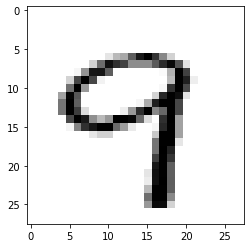

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


**Dataset visualisation for Image Augmentation**

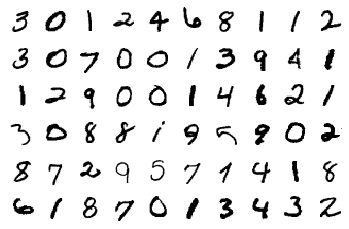

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

##**Round 5 Model**

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.10)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.10)
        ) # output_size = 12

        # CONVOLUTION BLOCK 2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.10)
        ) # output_size = 10

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.10)
        ) # output_size = 8
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.10)
        ) # output_size = 6

        # OUTPUT BLOCK
        #avgpool
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=6))

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.ReLU(),
            #nn.BatchNorm2d(10),
        ) # output_size = 1


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)

        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
         MaxPool2d-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 10, 12, 12]             160
             ReLU-10           [-1, 10, 12, 12]               0
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
           Conv2d-13           [-1, 10, 10, 10]             900
             ReLU-14           [-1,

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.3)
EPOCHS = 16
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

Loss=2.3062593936920166 Batch_id=1 Accuracy=16.41:   0%|          | 2/938 [00:00<01:14, 12.63it/s]

EPOCH: 0


Loss=0.04269104450941086 Batch_id=937 Accuracy=91.18: 100%|██████████| 938/938 [01:11<00:00, 14.00it/s]
Loss=0.10156512260437012 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:09, 13.43it/s]


Test set: Average loss: 0.0692, Accuracy: 9801/10000 (98.01%)

EPOCH: 1


Loss=0.11307267099618912 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [01:12<00:00, 13.48it/s]
Loss=0.04473483934998512 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:18, 11.97it/s]


Test set: Average loss: 0.0384, Accuracy: 9894/10000 (98.94%)

EPOCH: 2


Loss=0.13481411337852478 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [01:11<00:00, 14.41it/s]
Loss=0.014754172414541245 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:08, 13.60it/s]


Test set: Average loss: 0.0409, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.018225159496068954 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [01:11<00:00, 13.95it/s]
Loss=0.07738279551267624 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:17, 12.03it/s]


Test set: Average loss: 0.0323, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.009914935566484928 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [01:11<00:00, 13.68it/s]
Loss=0.19032016396522522 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:11, 13.09it/s]


Test set: Average loss: 0.0302, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.021193308755755424 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [01:10<00:00, 13.78it/s]
Loss=0.04132188856601715 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:09, 13.52it/s]


Test set: Average loss: 0.0318, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Loss=0.007122885901480913 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [01:10<00:00, 13.65it/s]
Loss=0.05534305050969124 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:10, 13.28it/s]


Test set: Average loss: 0.0234, Accuracy: 9935/10000 (99.35%)

EPOCH: 7


Loss=0.021234625950455666 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [01:10<00:00, 13.95it/s]
Loss=0.03555046394467354 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:10, 13.24it/s]


Test set: Average loss: 0.0258, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.02712630107998848 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [01:09<00:00, 14.34it/s]
Loss=0.1422308087348938 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:08, 13.67it/s]


Test set: Average loss: 0.0238, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.20428204536437988 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [01:09<00:00, 14.71it/s]
Loss=0.01592187024652958 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:08, 13.61it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.030291365459561348 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [01:09<00:00, 14.14it/s]
Loss=0.05788254365324974 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:12, 12.96it/s]


Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.0027336948551237583 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [01:11<00:00, 13.93it/s]
Loss=0.034776005893945694 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:12, 12.98it/s]


Test set: Average loss: 0.0243, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.04480305686593056 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [01:11<00:00, 13.70it/s]
Loss=0.039634861052036285 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:08, 13.73it/s]


Test set: Average loss: 0.0236, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.04691118746995926 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [01:10<00:00, 14.36it/s]
Loss=0.07187322527170181 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:10, 13.23it/s]


Test set: Average loss: 0.0239, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.01690584048628807 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [01:10<00:00, 13.63it/s]
Loss=0.029261566698551178 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:12, 12.98it/s]


Test set: Average loss: 0.0219, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=0.015943314880132675 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [01:10<00:00, 14.20it/s]



Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)



In [11]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 16
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

Loss=2.2618072032928467 Batch_id=1 Accuracy=19.53:   0%|          | 2/938 [00:00<01:11, 13.01it/s]

EPOCH: 0


Loss=0.023163478821516037 Batch_id=937 Accuracy=94.25: 100%|██████████| 938/938 [01:09<00:00, 14.90it/s]
Loss=0.08584834635257721 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:12, 12.97it/s]


Test set: Average loss: 0.0481, Accuracy: 9846/10000 (98.46%)

EPOCH: 1


Loss=0.046072088181972504 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [01:09<00:00, 14.67it/s]
Loss=0.03039950132369995 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:08, 13.63it/s]


Test set: Average loss: 0.0335, Accuracy: 9898/10000 (98.98%)

EPOCH: 2


Loss=0.02640216238796711 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [01:09<00:00, 13.99it/s]
Loss=0.11789079755544662 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:08, 13.69it/s]


Test set: Average loss: 0.0300, Accuracy: 9906/10000 (99.06%)

EPOCH: 3


Loss=0.02672511897981167 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [01:09<00:00, 14.00it/s]
Loss=0.006543632596731186 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:10, 13.24it/s]


Test set: Average loss: 0.0271, Accuracy: 9909/10000 (99.09%)

EPOCH: 4


Loss=0.0026630933862179518 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [01:09<00:00, 13.98it/s]
Loss=0.03851201757788658 Batch_id=1 Accuracy=95.31:   0%|          | 2/938 [00:00<01:14, 12.55it/s]


Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.009760289452970028 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [01:09<00:00, 13.93it/s]
Loss=0.03415888547897339 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:09, 13.50it/s]


Test set: Average loss: 0.0249, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.010326562449336052 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [01:09<00:00, 14.80it/s]
Loss=0.05058421939611435 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:09, 13.39it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 7


Loss=0.00803342554718256 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [01:09<00:00, 14.19it/s]
Loss=0.06289092451334 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:06, 14.04it/s]


Test set: Average loss: 0.0178, Accuracy: 9941/10000 (99.41%)

EPOCH: 8


Loss=0.2077205777168274 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [01:09<00:00, 14.89it/s]
Loss=0.0022482273634523153 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:10, 13.20it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.06643662601709366 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [01:09<00:00, 14.15it/s]
Loss=0.0006123107159510255 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:13, 12.75it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.051235996186733246 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [01:09<00:00, 14.59it/s]
Loss=0.02579420618712902 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:09, 13.52it/s]


Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.0022408284712582827 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [01:09<00:00, 14.24it/s]
Loss=0.07454697042703629 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:04, 14.52it/s]


Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)

EPOCH: 12


Loss=0.09749811887741089 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [01:09<00:00, 14.48it/s]
Loss=0.09618184715509415 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:10, 13.25it/s]


Test set: Average loss: 0.0184, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.003133457386866212 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [01:09<00:00, 14.38it/s]
Loss=0.0011753678554669023 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:04, 14.45it/s]


Test set: Average loss: 0.0172, Accuracy: 9948/10000 (99.48%)

EPOCH: 14


Loss=0.0011367358965799212 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [01:10<00:00, 14.89it/s]
Loss=0.0040581380017101765 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:09, 13.50it/s]


Test set: Average loss: 0.0169, Accuracy: 9948/10000 (99.48%)

EPOCH: 15


Loss=0.009435202926397324 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [01:09<00:00, 14.28it/s]



Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)



Text(0.5, 1.0, 'Test Accuracy')

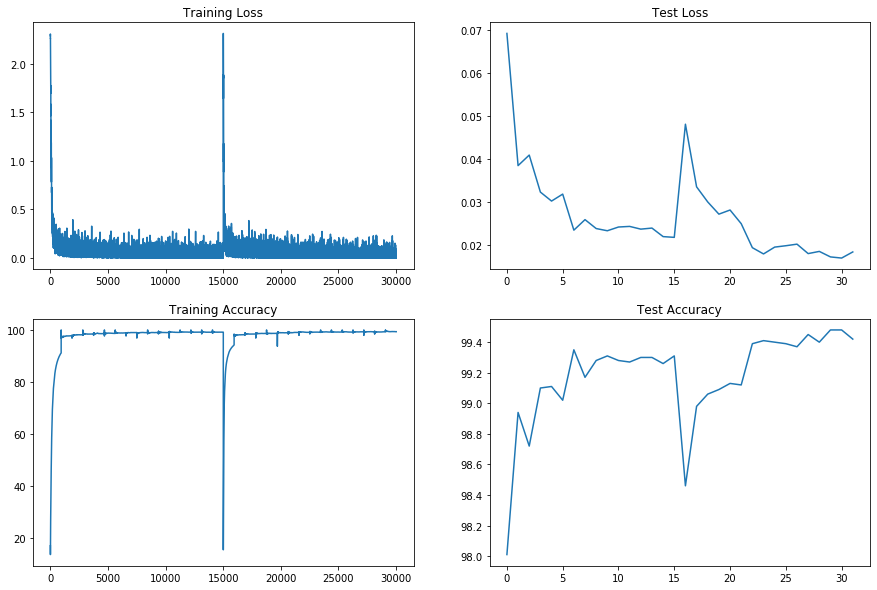

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")